## Todo
- make markdown neater/more consistent
- put the rest of functions/big code into py file.
- maybe reorganize
- explain renaming
- Add colorbar to geopandas
- find better way to upload files, maybe super compressed? put into multiple parts and have code to extract them all in the py file? or a new py file?
- Upload updated maps to website

In [3]:
import pandas as pd
import geopandas as gpd
from pandas import DataFrame
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import TemperatureGrapher

# In this project, I will be examining trends in global temperatures from the 18th century onwards and creating visuals to convey general conclusions. 

### Before going any further, I will open the data files and format them.

In [4]:
country_temps=pd.read_csv("GlobalLandTemperaturesByCountry.csv")
country_temps_average=country_temps.groupby("dt").mean()
world_temps=pd.read_csv("GlobalTemperatures.csv")
world_Landtemps_average=world_temps.groupby("dt").mean()
maj_city_temps=pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
state_temps=pd.read_csv("GlobalLandTemperaturesByState.csv")
state_temps_average=state_temps.groupby("dt").mean()
city_temps=pd.read_csv("GlobalLandTemperaturesByCity.csv")
city_temps_average=city_temps.groupby("dt").mean()


In [5]:
oldNames = ["Palestina", "Dominica","French Guiana", "Netherlands (Europe)", "Bosnia And Herzegovina", "United States", "Central African Republic", "Trinidad And Tobago", "Timor Leste", "Congo (Democratic Republic Of The)", "Côte D'Ivoire"]
newNames = ["Palestine", "Dominican Rep.", "Guinea", "Netherlands", "Bosnia and Herz.", "United States of America", "Central African Rep.", "Trinidad and Tobago", "Timor-Leste", "Dem. Rep. Congo", "Côte d'Ivoire"]
for i in range(len(oldNames)):
    country_temps.loc[country_temps["Country"] == oldNames[i], "Country"] = newNames[i]

# First, I drew a map using the latitude and longitude of each entry in the city temperatures data set to display the heat distribution in each century. Because there was little data in the 18th century, its map is less filled out than the others. 

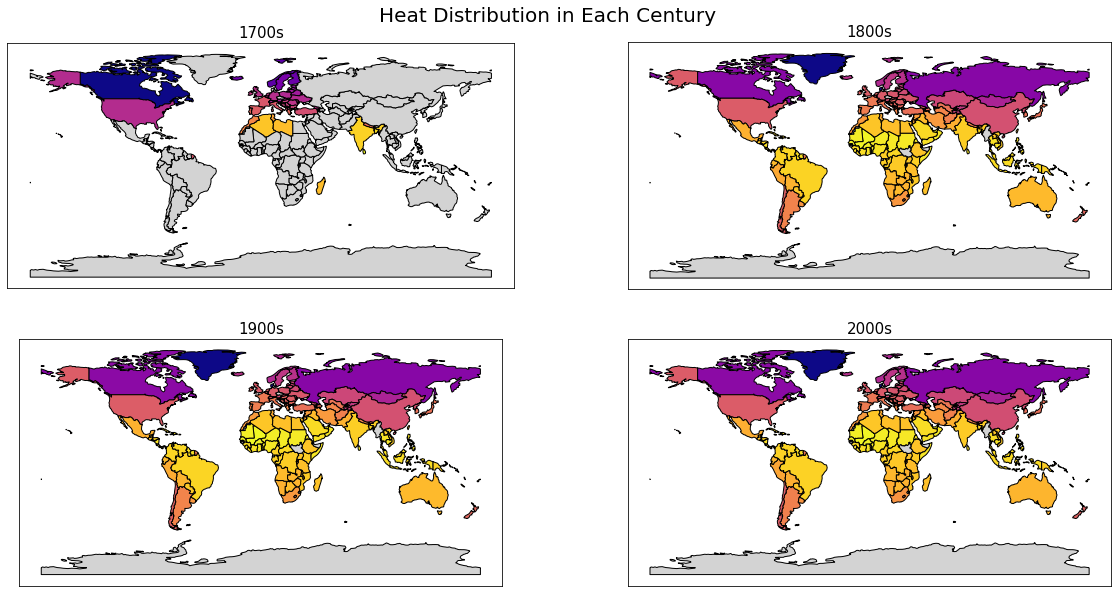

In [6]:
fig, heatAxs=plt.subplots(2,2, figsize=(20,10)) 
fig.patch.set_facecolor("white")
plt.suptitle("Heat Distribution in Each Century", fontsize=20,y=.93)

rows,columns = [0,0,1,1],[0,1,0,1]
for century in range(17,21):
    DF = country_temps[country_temps["dt"].str.startswith(str(century), na=False)]
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    for row in DF.groupby("Country"):
        country = row[1]["Country"].iloc[0]
        world.loc[world["name"] == country, "avgTemp"] = row[1]["AverageTemperature"].mean()
    row, column = rows.pop(0), columns.pop(0)
    world.plot(column = "avgTemp", edgecolor = "black", 
        missing_kwds = {"color": "lightgray", "edgecolor": "black"}, 
        cmap = "plasma", ax = heatAxs[row][column])
    heatAxs[row][column].tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
    heatAxs[row][column].set_title(str(century) + "00s", fontdict = {"fontsize":15})

# The following code will create four graph to display how the average temperature worldwide has changed each year. 
## The average temperature has been consistently increasing since the 18th century. In some graphs, there is a surge in the mid-1800s.
## Uncertainty about the data was much higher earlier on, but leveled off with time. 
### I created graphs using multiple datasets to ensure that the results were consistent. Each dataset provides temperatures monthly, but I averaged them out yearly to make the graphs more legible. 

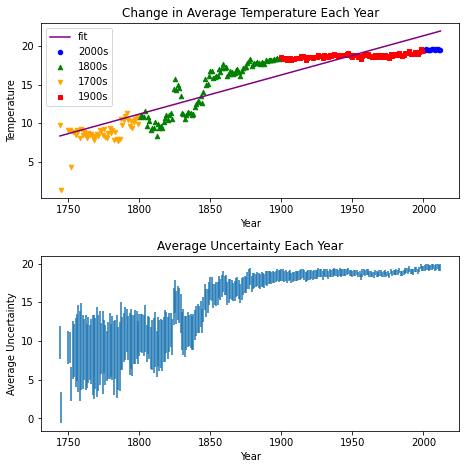

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.8322364167832591
The data above is from the country temperatures data set.


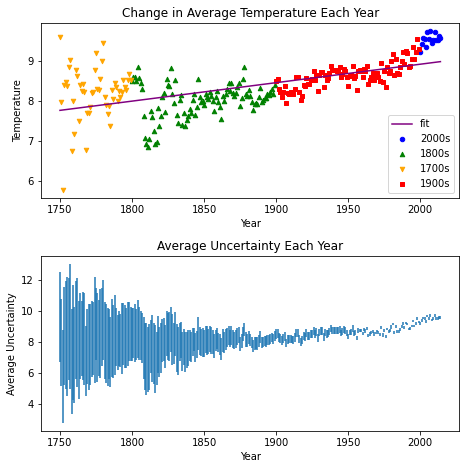

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.36278299432134453
The data above is from the world temperatures data set.


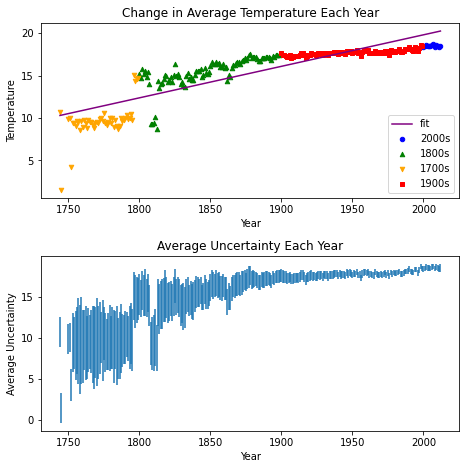

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.7468693180564441
The data above is from the city temperatures data set.


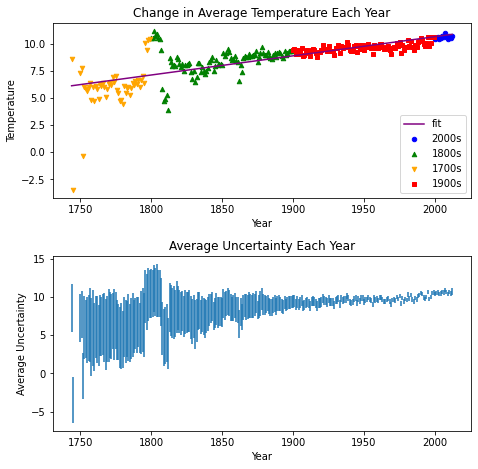

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.5521250477380277
The data above is from the state temperatures data set.


In [7]:
#Graphing the average temperature and uncertainty across different data sets.
TG = TemperatureGrapher.TemperatureGrapher()
TG.graph_data(country_temps_average, "AverageTemperature", country_temps_average, "AverageTemperatureUncertainty","country temperatures")
TG.graph_data(world_Landtemps_average, "LandAverageTemperature", world_Landtemps_average, "LandAverageTemperatureUncertainty","world temperatures")
TG.graph_data(city_temps_average, "AverageTemperature", city_temps_average, "AverageTemperatureUncertainty","city temperatures")
TG.graph_data(state_temps_average, "AverageTemperature", state_temps_average, "AverageTemperatureUncertainty","state temperatures")

# Below, I will display which areas have had the highest increase in temperature. 
## It is important to note that different areas began recording temperatures at different times. As a result, places that began recording later will have fewer low temperatures recorded (due to the consistent increase in temperatures with time), weighing down their average. To avoid a possible misrepresentation, I grouped the areas based on when they began recording. 

In [8]:
def group_by_century(df, place_type):
    curr_place=None
    century_began={1700:[], 1750:[],1800:[], 1850:[],1900:[], 1950:[],2000:[]} #Each place will be placed in a list depending on when it began recording temperatures.
    index=1
    avg_temps=df.groupby(place_type).mean()
    avg_temps['AverageTemperature'] = avg_temps['AverageTemperature'].replace(np.nan, 0)
    for column in df: #This loop will figure out the indeces of the "dt" column and the place name column. 
        if column=="dt":
            dt_index=index
        elif column==place_type:
            place_index=index
        index+=1
    index=0
    for row in df.itertuples(): #This will iterate through each entry in the data frame. 
        dt,place=row[dt_index],row[place_index]
        if curr_place==place: #If curr_place==place, then we are not at the place's first entry (when they began recording temperatures). We only need the first entry of each place.
            continue
        elif curr_place==None or curr_place!=place: 
            curr_place=place
            year_began=int(dt[:4])#This will record the year of the first year a place began recording temperatures.
        #The conditionals below will classify the place based on when it began recording temperatures.
        if int(str(year_began)[2])<5:#If the third number of the year is less than 5 (e.g. 1846 4<5).
            century_began[int(str(year_began)[:2]+"00")].append([curr_place,index,avg_temps.loc[curr_place]["AverageTemperature"]])#This takes the first two numbers of the yera (which tells us the century) and adds 00 to it. It needs to temporarily be a string to concatonate the two. E.g. 1846 will become 1800.
        else:
            century_began[int(str(year_began)[:2]+"50")].append([curr_place,index,avg_temps.loc[curr_place]["AverageTemperature"]])
        index+=1
    return century_began
def highest_avg(century_began, type_place, index1, index2):
    highest_places,highest_temps=[],[]
    for century in century_began:
        if len(century_began[century])>0:#If no areas began recording temperatures after a specific time period like 2000, the list would be empty.
            sorted_list=sorted(century_began[century], key = lambda x: int(x[2]), reverse=True) #Sorts the list by average temperature. It's fine to hardcode the index of average temperature because the code that creates the list ensures that an average temperature is always recorded.
            #If a place had no recorded temperatures (resulting in the average temperature being NaN), it was replaced with 0.0 in the group_by_century function to act as a placeholder of sorts. 
            if sorted_list[0][2]>0.0: 
                highest_places.append(sorted_list[0][0])
                highest_temps.append(sorted_list[0][2])
    
    bar_top_temps = timeAxs[index1][index2].bar(highest_places, highest_temps, color=['b','r','g','orange','purple','pink','orange'])
    #The code below is from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
    colors = {'1700':'blue', '1750':'red', '1800':'green','1850':'orange', '1900': 'purple', '1950': 'pink', '2000': "yellow"}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    #The code below is from https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 1),prop={'size': 12.5})
    timeAxs[index1][index2].set(xlabel=type_place, ylabel='Temperature')
    timeAxs[index1][index2].set_xticks(range(len(highest_places))) #This sets the tick locations based on how many entries are in the list.
    timeAxs[index1][index2].set_xticklabels(labels=highest_places,rotation=25)


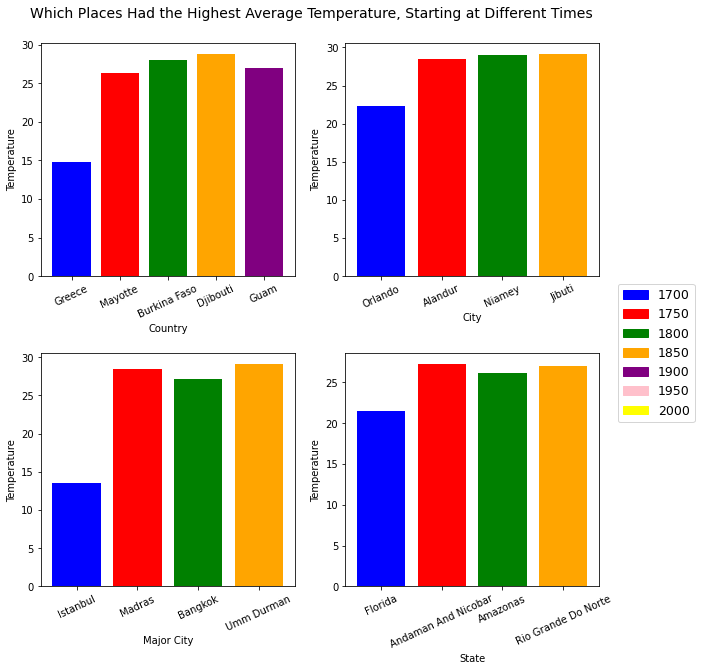

In [9]:
fig, timeAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.subplots_adjust(hspace=.33)
plt.suptitle("Which Places Had the Highest Average Temperature, Starting at Different Times", fontsize=14,y=.93)
highest_avg(group_by_century(country_temps, "Country"), "Country",0,0)
highest_avg(group_by_century(city_temps, "City"), "City",0,1)
highest_avg(group_by_century(maj_city_temps, "City"), "Major City",1,0)
highest_avg(group_by_century(state_temps, "State"), "State",1,1)
